Перед запуском всего ноутбука необходимо в отдельной консоли запустить mlflow server:

`mlflow server --host 127.0.0.1 --port 8080`

In [1]:
import polars as pl
from pathlib import Path

amazon_root = Path('Amazon reviews')
df = pl.read_csv(amazon_root / 'train.csv', n_rows=50000)

In [2]:
df.columns = ['Polarity', 'Title', 'Review']
pl.Config.set_fmt_str_lengths(100)
df.head(3)

Polarity,Title,Review
i64,str,str
2,"""The best soundtrack ever to anything.""","""I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd …"
2,"""Amazing!""","""This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners of …"
2,"""Excellent Soundtrack""","""I truly like this soundtrack and I enjoy video game music. I have played this game and most of the …"


In [3]:
df = df.select('Polarity', 'Review').with_columns(
    pl.col("Polarity").map_elements(
        lambda polarity: "Negative" if polarity == 1 else "Positive"
    )
)

Датасет сбалансирован по отзывам:

In [4]:
df['Polarity'].value_counts()

Polarity,count
str,u32
"""Negative""",24494
"""Positive""",25506


В этом ноутбуке применим метод классификации на основе частотного подсчета TF-IDF:
- TF: term frequency отвечает за частоту встречаемости слова в текущем сообщении
- IDF: inverse document frequency отвечает за "редкость" слова, насколько слово редко встречается в других сообщениях

Для этого сделаем предобработку текста:

In [5]:
from nltk.corpus import stopwords
import nltk
import re

def preprocessing(input_text: str) -> str:
    nltk.download('stopwords')
    text = input_text.lower() # приведение к нижнему регистру
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]|[^a-zA-Z\s]+|\w*\d\w*', '', text) # убираем ссылки
    text = re.sub("[0-9 \-_]+", " ", text) # убираем спец символы
    text = re.sub("[^a-z A-Z]+", " ", text) # оставляем только буквы
    text = " ".join( # убираем стоп слова
        [word for word in text.split() if word not in stopwords.words("english")]
    )
    return text.strip()

df = df.with_columns(
    pl.col('Review').map_elements(preprocessing).str.split(' ').alias('corpus')
)

df.head(5)

Polarity,Review,corpus
str,str,list[str]
"""Positive""","""I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd …","[""im"", ""reading"", … ""penny""]"
"""Positive""","""This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners of …","[""soundtrack"", ""favorite"", … ""stars""]"
"""Positive""","""I truly like this soundtrack and I enjoy video game music. I have played this game and most of the …","[""truly"", ""like"", … ""cross""]"
"""Positive""","""If you've played the game, you know how divine the music is! Every single song tells a story of the…","[""youve"", ""played"", … ""paper""]"
"""Positive""","""I am quite sure any of you actually taking the time to read this have played the game at least once…","[""quite"", ""sure"", … ""ever""]"


Как вариант для сокращения разных комбинаций одного и того же слова лемматизируем слова, то есть вместо reading -> read, приводим к единой лемме. На русском языке это также убрало бы падежи.

In [6]:
from nltk.stem import WordNetLemmatizer

def lemmatize(input_frame: pl.DataFrame) -> pl.DataFrame:
    lemmatizer = WordNetLemmatizer()

    return input_frame.with_columns(
        pl.col("corpus").map_elements(
            lambda input_list: [lemmatizer.lemmatize(token) for token in input_list]
        )
    )
    
df = lemmatize(df)
df.head(5)

Polarity,Review,corpus
str,str,list[str]
"""Positive""","""I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd …","[""im"", ""reading"", … ""penny""]"
"""Positive""","""This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners of …","[""soundtrack"", ""favorite"", … ""star""]"
"""Positive""","""I truly like this soundtrack and I enjoy video game music. I have played this game and most of the …","[""truly"", ""like"", … ""cross""]"
"""Positive""","""If you've played the game, you know how divine the music is! Every single song tells a story of the…","[""youve"", ""played"", … ""paper""]"
"""Positive""","""I am quite sure any of you actually taking the time to read this have played the game at least once…","[""quite"", ""sure"", … ""ever""]"


Разобьем на train/test split, получим признаки для train и test:

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

random_state = 42
vectorizer_params = {
    "max_features": 10000,
    "analyzer": "word"
}

tfidf_vectorizer = TfidfVectorizer(**vectorizer_params)

train, test = train_test_split(
    df,
    test_size=0.3,
    shuffle=True,
    random_state=random_state,
)

tfidf_vectorizer.fit(train["corpus"].to_pandas().astype(str))
train_features = tfidf_vectorizer.transform(train["corpus"].to_pandas().astype(str))
test_features = tfidf_vectorizer.transform(test["corpus"].to_pandas().astype(str))

Вспомогательный код для получения Confusion матрицы:

In [32]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from sklearn.metrics import (
    ConfusionMatrixDisplay,
)

def conf_matrix(y_true: np.ndarray, pred: np.ndarray) -> Figure:
    plt.ioff()
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(y_true, pred, ax=ax, colorbar=False)
    ax.xaxis.set_tick_params(rotation=90)
    _ = ax.set_title(f"Confusion Matrix")
    plt.tight_layout()
    return fig

Теперь будем использовать mlflow для логирования результатов обучение логистической регрессии:

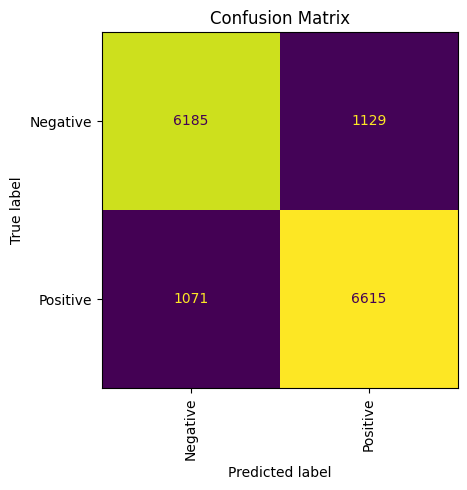

In [33]:
import mlflow
from sklearn.metrics import classification_report

# Подключение к серверу MLflow
mlflow.set_tracking_uri("http://127.0.0.1:8080")
# Зафиксируем текущее название эксперимента
embeddings_experiment = mlflow.set_experiment("Embeddings_50k")

# Зафиксируем название текущего запуска, если не фиксировать, оно автосгенерируется
tf_idf_run_name = "tf_idf_embeddings"

with mlflow.start_run(run_name=tf_idf_run_name) as run:
    model_params = {
        "multi_class": "multinomial",
        "solver": "saga",
        "random_state": random_state,
    }
    model_lr = LogisticRegression(**model_params)
    model_lr.fit(train_features, train["Polarity"])
    predicts = model_lr.predict(test_features)
    report = classification_report(test["Polarity"], predicts, output_dict=True)

    # логирование метрик из classification report
    mlflow.log_metric("accuracy", report.pop("accuracy"))
    for class_or_avg, metrics_dict in report.items():
        if class_or_avg == 'macro avg':
            break
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric, value)
    
    # Логирование параметров модели
    mlflow.log_params(vectorizer_params) 
    mlflow.log_params(model_params)

    # Логирование целой модели для переиспользование
    mlflow.sklearn.log_model(
        sk_model=model_lr, 
        input_example=test_features[:10], 
        artifact_path=f"mlflow/{tf_idf_run_name}/model"
    )
    
     # Получение confusion matrix на два класса
    fig = conf_matrix(test["Polarity"], predicts)
    
    # Логирование фигур или целых артефактов
    mlflow.log_figure(fig, f'{tf_idf_run_name}_confusion_matrix.png')

Альтернативно можно попросить mlflow самостоятельно залогировать метрики. для этого перед with выше нужно написать: mlflow.autolog(), но лучше самому в явном виде определять, что ожидается увидеть в дашборде.